# Imports

The **services module** contains functions for accessing third party bioemdical data services.

In [1]:
from services.pdb import pfam, pdbligand, pdbmolecule
from services.classyfire import classyfire
from services.uniprot import pdb2uniprot
from services.pubchem import get_image

##### PDB
For PDB we have functions for quering information about (1) PDB files, (2) Protein Molecules, (3) Ligands, (4) PFam Annotations and (5) GO annotations.  

##### Uniprot
For Uniprot we query a service that maps pdb IDs to uniprot IDs. 

# Pocket Feature Graph

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

##### Step 1. Convert pocket feature scores to "cosine similarities"

Given a matrix $X \in \mathbb R ^n$ with rows $x_i$, we compute the cosine similarity between two rows as:

$$ \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$

Given symmetric positive semidefinite matrix $A = X X^T$, we can compute cosine similarities using hte formula:

$$\frac{a_{ij}}{\sqrt{a_{ii}}\sqrt{a_{jj}}} = \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$ 

In [3]:
# Read in pocket feature similarities and convert to an adjacency matrix
pf = pd.read_csv('./data/pocket_feature_scores.csv', header=None, names=['pocket_0', 'pocket_1', 'weight'])
pf_matrix = pf.pivot(index='pocket_0', columns='pocket_1', values='weight')

# Compute cosine similarities from pocket feature score matrix
diagonal = np.sqrt(np.diag(-1*pf_matrix))
denominator = np.outer(diagonal, diagonal)
normalized = (-1*pf_matrix)/denominator

##### Step 2. Filter cosine similarities

In order to reduce memory and computational costs, we filter out cosine slimilarity values that fall outside of a range of interest.  For example, we may wish to exclude low similarity values.  Likewise, we do not wish to have self referencing edges in our graph, so we also filter out diagonal values in the adjacency matrix.

In [4]:
# Specify desired range
score_range = [0.65, 1]
lower_limit = score_range[0]
upper_limit = score_range[1]

# Set matrix entries out of specificed range to NaN
if lower_limit > 0:
    normalized[normalized < lower_limit] = np.nan
if upper_limit < 1:
    normalized[normalized > upper_limit] = np.nan

# Set off Diagonal to NaN
np.fill_diagonal(normalized.values, np.nan)

##### Step 3. Initialize PF Similarity Graph

In [5]:
# Convert from adjacency matrix to edge list
normalized_edges = normalized.stack().reset_index()
normalized_edges = normalized_edges.rename(columns={0:'weight'})

In [6]:
# Split off ligand IDs from pocket IDs and add them as separate columns
new = normalized_edges['pocket_0'].str.split("_", expand = True)
normalized_edges['ligand_0'] = new[1]

new = normalized_edges['pocket_1'].str.split("_", expand = True)
normalized_edges['ligand_1'] = new[1]

In [7]:
# Initialize graph
PFG = nx.Graph()

# Iterate through rows of edge list dataframe
for row in normalized_edges.itertuples():
    
    # If both ligand are the same, do nothing
    ligand_0 = row.ligand_0
    ligand_1 = row.ligand_1
    if ligand_0 == ligand_1:
        continue
        
    # If ligands are different, we pull out pocket IDs and pf cosine similarity
    pocket_0 = row.pocket_0    
    pocket_1 = row.pocket_1
    weight = row.weight
    
    # If we have not seen this pair of ligand before, we add an edge
    if not PFG.has_edge(ligand_0, ligand_1):
        PFG.add_edge(ligand_0, ligand_1, id=[pocket_0, pocket_1], weight=weight)
        
    # Otherise update the edge weight if pf cosine similarity is greater than previous max
    elif weight > PFG[ligand_0][ligand_1]['weight']:
        PFG[ligand_0][ligand_1]['weight'] = weight

# Scaffold Hop Scores

We define a scaffold hop score for a pair of ligands as:

$$max\left(\frac{F(m_1, m_2)}{T(m_1,m_2)}\right)$$

Where $m_i$ denotes a ligand in our dataset, $F$ is the pocket feature cosine similarity between bound protein structures, and $T$ is the tanomoto coefficient between chemical fingerprints.  Ligands may be bound in multiple co-crystal structures, and for any pair of ligands there may be a range of scaffold hop scores.  We take the maximum value.  In general, the high scaffold hop scores corrspond to ligands with dissimilar strucutres, that bind slimilar protein pockets.

In [3]:
# Import ligand tanomoto matrix
ligand_matrix = pd.read_csv('./data/ligand_comparisons.csv', index_col=0)

In [9]:
for ligand_0, ligand_1 in PFG.edges:
    ligand_score = ligand_matrix[ligand_0][ligand_1]
    pf_score = PFG[ligand_0][ligand_1]['weight']
    
    PFG[ligand_0][ligand_1]['weight'] = pf_score/ligand_score

# Results

In [10]:
from pprint import pprint

pprint(sorted(PFG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])
sorted_scores = sorted(PFG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

[('4B0', 'AGI', {'id': ['4dgm_AGI', '3ofm_4B0'], 'weight': 3.863692098280909}),
 ('E3O', 'GEN', {'id': ['2j7y_E3O', '1x7r_GEN'], 'weight': 3.5680618401206634}),
 ('1CY', 'CP6', {'id': ['3irm_1CY', '2bl9_CP6'], 'weight': 3.41845238095238}),
 ('GLT', 'ASC', {'id': ['1xli_GLT', '1xid_ASC'], 'weight': 3.3527563527575506}),
 ('H4B', '7AP', {'id': ['3e7g_H4B', '2g6j_7AP'], 'weight': 3.2920030757401}),
 ('GEN', 'WST', {'id': ['2pog_WST', '1x7r_GEN'], 'weight': 3.2362680667388037}),
 ('IL2', 'L41', {'id': ['3sp9_IL2', '3d5f_L41'], 'weight': 3.1320808844387567}),
 ('WST', '0L8', {'id': ['4dma_0L8', '2pog_WST'], 'weight': 3.0974968770168076}),
 ('PDN', 'WFG', {'id': ['3wfg_WFG', '2aax_PDN'], 'weight': 3.088382943045454}),
 ('E3O', '0L8', {'id': ['4dma_0L8', '2j7y_E3O'], 'weight': 3.0849106955153673})]


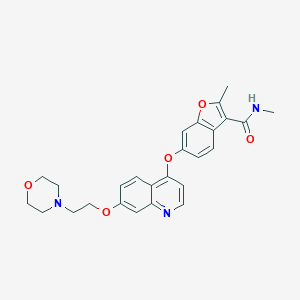

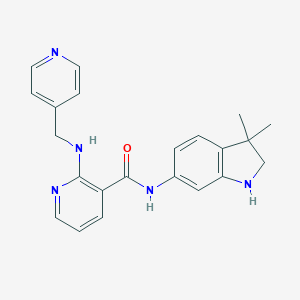

In [11]:
import IPython.display as Disp

# image size can be 'large' or 'small'
image_size = 'large'

idx = 118
edge = sorted_scores[idx]
lig_0 = edge[0]
lig_1 = edge[1]

lig_info = pdbligand( ','.join([lig_0, lig_1]) )
keys = ['chemicalID','chemicalName', 'formula', 'molecularWeight']
classes = []
for info in lig_info:
    inchi = info['InChIKey']
    co_classes = classyfire(inchi)
    classes.append(co_classes)
    txt = [co_classes['direct_parent']['name'], co_classes['description']]
    image = get_image(inchi, image_size=image_size)
#     url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchi}/PNG?image_size={image_size}' 
#     image = requests.get(url).content
    text = '<br>'.join( [info[key].upper() for key in keys] + txt )
    Disp.display( Disp.Image(image), Disp.HTML(text) )

In [12]:
def extract_pdbids(edge_data):
    pdbs = edge_data['id']
    return ','.join([i.split('_')[0] for i in pdbs])

pprint(pdbmolecule(extract_pdbids(edge[2])))

[{'id': '3EFL',
  'polymer': {'Taxonomy': {'id': '9606', 'name': 'Homo sapiens'},
              'chain': [{'id': 'A'}, {'id': 'B'}],
              'entityNr': '1',
              'enzClass': {'ec': '2.7.10.1'},
              'fragment': {'desc': 'kinase domain, Unp residues 815-939, 990- '
                                   '1171'},
              'length': '314',
              'macroMolecule': {'accession': {'id': 'P35968'},
                                'name': 'Vascular endothelial growth factor '
                                        'receptor 2'},
              'mutation': {'desc': 'C817A, E990V'},
              'polymerDescription': {'description': 'Vascular endothelial '
                                                    'growth factor receptor 2'},
              'synonym': {'name': 'VEGFR-2, Kinase insert domain receptor, '
                                  'Protein-tyrosine kinase receptor Flk-1, '
                                  'CD309 antigen'},
              'type': 'p

In [13]:
pprint(classes)

[{'alternative_parents': [{'chemont_id': 'CHEMONTID:0001253',
                           'description': 'Compounds containing a quinoline '
                                          'moiety, which consists of a benzene '
                                          'ring fused to a pyrimidine ring to '
                                          'form benzo[b]azabenzene.',
                           'name': 'Quinolines and derivatives',
                           'url': 'http://classyfire.wishartlab.com/tax_nodes/C0001253'},
                          {'chemont_id': 'CHEMONTID:0000301',
                           'description': 'Organic compounds containing a '
                                          'benzene ring fused to a furan. '
                                          'Furan is a five-membered aromatic '
                                          'ring with four carbon atoms and one '
                                          'oxygen atom.',
                           'name': 'Benzof

In [226]:
info

{'chemicalID': '706',
 'type': 'non-polymer',
 'molecularWeight': '373.451',
 'chemicalName': 'N-(3,3-dimethyl-2,3-dihydro-1H-indol-6-yl)-2-[(pyridin-4-ylmethyl)amino]pyridine-3-carboxamide',
 'formula': 'C22 H23 N5 O',
 'InChIKey': 'RAHBGWKEPAQNFF-UHFFFAOYSA-N',
 'InChI': 'InChI=1S/C22H23N5O/c1-22(2)14-26-19-12-16(5-6-18(19)22)27-21(28)17-4-3-9-24-20(17)25-13-15-7-10-23-11-8-15/h3-12,26H,13-14H2,1-2H3,(H,24,25)(H,27,28)',
 'smiles': 'CC1(CNc2c1ccc(c2)NC(=O)c3cccnc3NCc4ccncc4)C'}